<a href="https://colab.research.google.com/github/sainiakhil/Predict-Student-Dropout-Risk-in-an-E-Learning-Platform/blob/main/Predict_Student_Dropout_Risk_in_an_E_Learning_Platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df  = pd.read_csv("/content/learning_data(learning_data).csv")
df.head()

,student_id,age,gender,course_type,session_count,avg_session_duration,quiz_attempts,assignments_submitted,satisfaction_rating,dropout
0,S0001,24,Male,UI/UX,11,108.13,7,5,5,0
1,S0002,37,Male,Python,9,59.51,3,1,1,1
2,S0003,32,Male,UI/UX,15,81.77,3,3,1,1
3,S0004,28,Female,Digital Marketing,7,24.82,4,4,1,1
4,S0005,25,Female,Digital Marketing,5,27.11,7,1,4,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   student_id             200 non-null    object 
 1   age                    200 non-null    int64  
 2   gender                 200 non-null    object 
 3   course_type            200 non-null    object 
 4   session_count          200 non-null    int64  
 5   avg_session_duration   200 non-null    float64
 6   quiz_attempts          200 non-null    int64  
 7   assignments_submitted  200 non-null    int64  
 8   satisfaction_rating    200 non-null    int64  
 9   dropout                200 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 15.8+ KB


In [3]:
# removing student_id column from df
df.drop(columns=['student_id'], inplace=True)

In [4]:
# storing dropout column in different variable
target = df.dropout
df = df.drop(columns=['dropout'])

In [5]:
target.unique()

array([0, 1])

In [16]:
print(df.isnull().sum())

age                      0
gender                   0
course_type              0
session_count            0
avg_session_duration     0
quiz_attempts            0
assignments_submitted    0
satisfaction_rating      0
dtype: int64


In [24]:
target.value_counts()

,count
dropout,
0,103
1,97


In [6]:
df.course_type.unique()

array(['UI/UX', 'Python', 'Digital Marketing'], dtype=object)

In [7]:
df.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [6]:
le = LabelEncoder()
for col in df.select_dtypes(include=['category', 'object']):
    df[col] = le.fit_transform(df[col])

In [7]:
scaler = StandardScaler()

scaled_df  = scaler.fit_transform(df)

In [8]:
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.head()

,age,gender,course_type,session_count,avg_session_duration,quiz_attempts,assignments_submitted,satisfaction_rating
0,-0.600994,0.416659,1.285148,-0.384722,1.543930,0.937751,1.526562,1.356727
1,1.428337,0.416659,0.111497,-0.610036,0.011029,-0.461877,-0.804067,-1.484586
2,0.647825,0.416659,1.285148,0.065904,0.712846,-0.461877,0.361247,-1.484586
3,0.023415,-1.071410,-1.062155,-0.835349,-1.082685,-0.111970,0.943905,-1.484586
4,-0.444892,-1.071410,-1.062155,-1.060662,-1.010485,0.937751,-0.804067,0.646399


### Correlations between features and a target variable

In [9]:
scaled_df['dropout'] = target

In [10]:
correlations = scaled_df.corr()['dropout'].drop('dropout') # Drop self-correlation
print("Feature Correlations with Dropout:\n", correlations)

Feature Correlations with Dropout:
 age                      0.116427
gender                  -0.057168
course_type              0.014266
session_count           -0.475913
avg_session_duration     0.051648
quiz_attempts           -0.073654
assignments_submitted    0.064937
satisfaction_rating     -0.332086
Name: dropout, dtype: float64


### Data Visualization

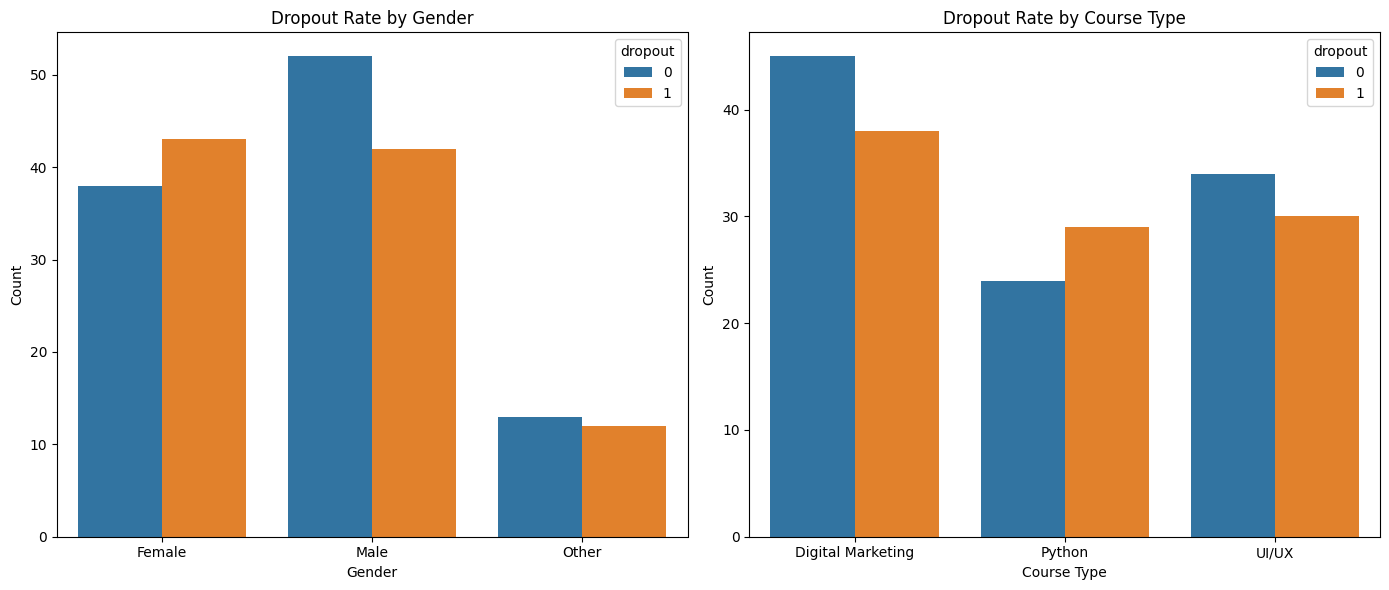

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Gender vs. Dropout ---
sns.countplot(ax=axes[0], x='gender', hue='dropout', data=scaled_df)
axes[0].set_title('Dropout Rate by Gender')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Female', 'Male', 'Other'])
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

# --- Plot 2: Course Type vs. Dropout ---
sns.countplot(ax=axes[1], x='course_type', hue='dropout', data=scaled_df)
axes[1].set_title('Dropout Rate by Course Type')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['Digital Marketing', 'Python', 'UI/UX'])
axes[1].set_xlabel("Course Type")
axes[1].set_ylabel("Count")


plt.tight_layout()
plt.show()


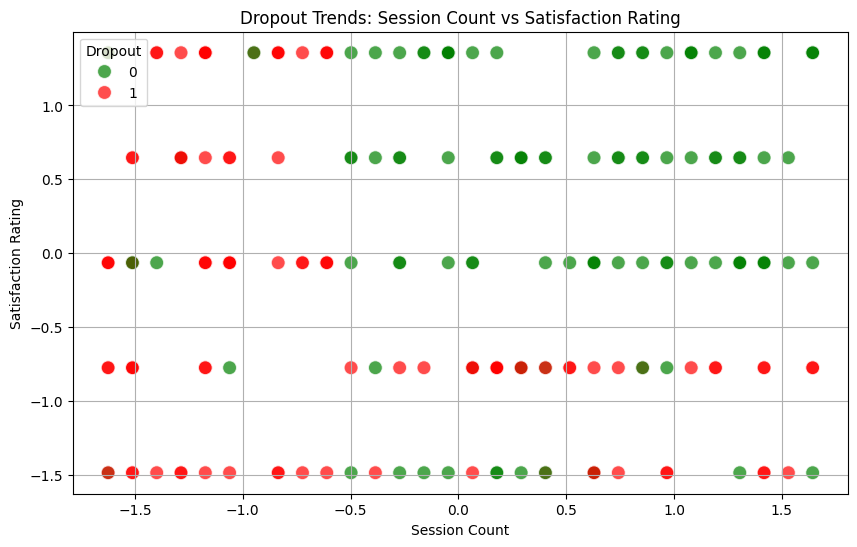

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scaled_df,
    x='session_count',
    y='satisfaction_rating',
    hue='dropout',
    palette={0: 'green', 1: 'red'},
    s=100,
    alpha=0.7
)

plt.title("Dropout Trends: Session Count vs Satisfaction Rating")
plt.xlabel("Session Count")
plt.ylabel("Satisfaction Rating")
plt.grid(True)
plt.legend(title='Dropout' )
plt.show()

### Model Building

In [11]:
X = scaled_df.drop('dropout', axis=1)
y = scaled_df['dropout']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
  # Cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

  # Train the model
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1] # Probability of positive class

  # Evaluate the model
  results[name] = {
      'accuracy': accuracy_score(y_test, y_pred),
      'precision': precision_score(y_test, y_pred),
      'recall': recall_score(y_test, y_pred),
      'f1': f1_score(y_test, y_pred),
      'roc_auc': roc_auc_score(y_test, y_prob),
      'cv_scores': cv_scores
  }
  print(f'{name}:')
  print(f"  Accuracy: {results[name]['accuracy']:.4f}")
  print(f"  Precision: {results[name]['precision']:.4f}")
  print(f"  Recall: {results[name]['recall']:.4f}")
  print(f"  F1-Score: {results[name]['f1']:.4f}")
  print(f"  ROC-AUC Score: {results[name]['roc_auc']:.4f}")
  print(f"  Cross-Validation Scores: {results[name]['cv_scores']}")


# Feature importance (for Random Forest)
if "Random Forest" in models:
    feature_importances = models["Random Forest"].feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
    print("\nRandom Forest Feature Importance:")
    print(feature_importance_df)

# Feature Coefficients (for Logistic Regression)
if "Logistic Regression" in models:
    coefficients = models["Logistic Regression"].coef_[0]
    coefficient_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients}).sort_values(by='Coefficient', ascending=False)
    print("\nLogistic Regression Coefficients:")
coefficient_df

Logistic Regression:
  Accuracy: 0.7750
  Precision: 0.7000
  Recall: 0.8235
  F1-Score: 0.7568
  ROC-AUC Score: 0.7877
  Cross-Validation Scores: [0.71875 0.90625 0.84375 0.59375 0.78125]
Random Forest:
  Accuracy: 0.8000
  Precision: 0.7143
  Recall: 0.8824
  F1-Score: 0.7895
  ROC-AUC Score: 0.8900
  Cross-Validation Scores: [0.875   0.90625 0.875   0.8125  0.875  ]

Random Forest Feature Importance:
                 Feature  Importance
3          session_count    0.350333
7    satisfaction_rating    0.200745
4   avg_session_duration    0.134002
0                    age    0.095499
5          quiz_attempts    0.085563
6  assignments_submitted    0.064982
2            course_type    0.040909
1                 gender    0.027968

Logistic Regression Coefficients:


,Feature,Coefficient
4,avg_session_duration,0.451094
0,age,0.241023
6,assignments_submitted,-0.051263
1,gender,-0.088797
5,quiz_attempts,-0.129497
2,course_type,-0.192824
7,satisfaction_rating,-1.000771
3,session_count,-1.385643


### Model interpretability using SHAP Package

(8, 2)
(40, 8)


<Figure size 640x480 with 0 Axes>

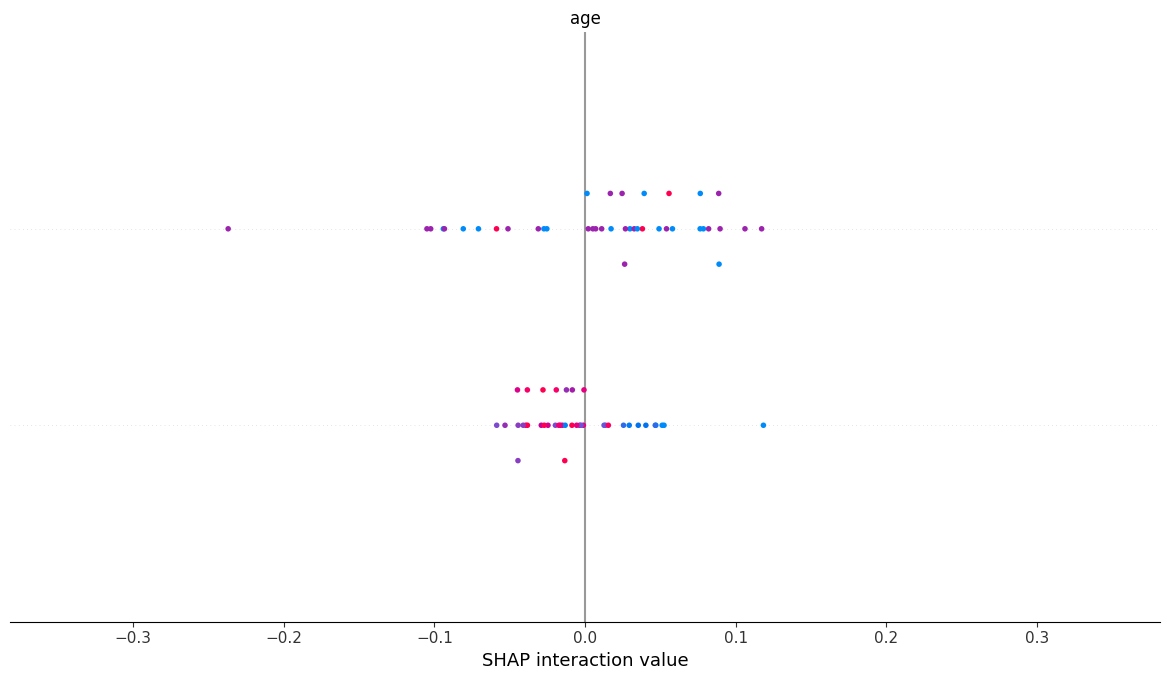

<Figure size 640x480 with 0 Axes>

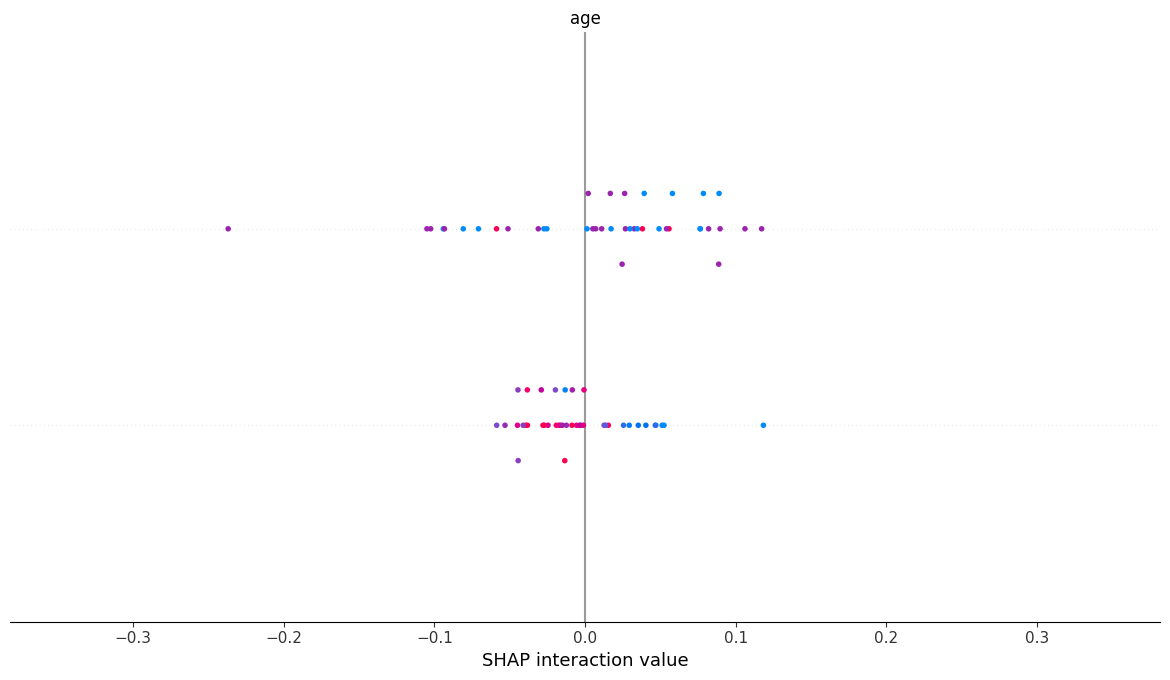

In [14]:
import numpy as np
import shap

model = models["Random Forest"]

explainer = shap.TreeExplainer(model) # Use TreeExplainer for tree-based models like RandomForest
shap_values = explainer.shap_values(X_test)

print(np.shape(shap_values[1]))
print(X_test.shape)

# Visualize the first prediction's explanation (summary plot)
shap.summary_plot(shap_values, X_test) # Index 1 is for the positive class in binary classification


# Visualize the most important features for all predictions (beeswarm plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Basic Student Engagement Strategy Using Your Predictions

In [31]:
# --- Basic Student Engagement Strategy based on SHAP values ---
def suggest_engagement_strategy(student_data):
    # Calculate SHAP values for the specific student data
    student_shap_values = explainer.shap_values(student_data)

    # Identify top features influencing dropout risk (positive SHAP values increase risk)
    top_features = np.argsort(student_shap_values)[-3:]  # Get the indices of top 3 features

    strategy = ""
    for feature_index_tuple in top_features:
      feature_index = feature_index_tuple[0]
      feature_name = X_test.columns[feature_index]
      if feature_name.values[0] == "session_count":
          strategy += "Encourage more active participation in sessions and provide additional support if needed. "
      elif feature_name.values[0] == "satisfaction_rating":
          strategy += "Address any concerns or frustrations regarding the course content or learning experience. Consider personalized feedback or additional resources. "
      elif feature_name.values[0] == "gender":
          strategy += "Check for gender-specific learning preferences or if any support systems are required." #Example strategy - further research on this would be needed
      elif feature_name.values[0] == "course_type":
              strategy += "Ensure the student is on the right learning path for their desired outcome, consider more personalized or alternative resources for the course type"
      else:
          strategy += f"Investigate the {feature_name} further for potential improvements or guidance."

    return strategy


# Example usage:
example_student = X_test.iloc[0].to_frame().T
example_student_numpy = example_student.values

suggested_strategy = suggest_engagement_strategy(example_student_numpy)
print(f"\nSuggested engagement strategy for example student:\n{suggested_strategy}")



Suggested engagement strategy for example student:
Investigate the Index(['age', 'gender'], dtype='object') further for potential improvements or guidance.
